In [1]:
# Import necessary libaries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(file1, file2, file3):
    # define global variables
    global emails
    
    # Specify data folder
    data_folder = 'Data'
    
    # Read the data
    email_1 = pd.read_csv(os.path.join(data_folder,file1),
                        usecols=['Body', 'Label'])
    email_2 = pd.read_csv(os.path.join(data_folder,file2),
                        usecols=['Body', 'Label'])
    email_3 = pd.read_csv(os.path.join(data_folder,file3),
                        usecols=['Body', 'Label'])
    emails = pd.concat([email_1, email_2, email_3], axis=0)


In [88]:
def prep_data(data):
    # define global variables
    global email_train, email_test, label_train, label_test, vec
    
    # Drop null values in the data
    data.dropna(inplace=True)
    
    # Add a new column that stores the lenth of each email body
    data['email_length'] = data['Body'].apply(len)
    
    # DATA PREPARATION
    # Drop insignificant emails
    insignif_emails = data[emails['email_length']<10]
    data.drop(inplace=True, index=insignif_emails.index)
    
    # Replace https with blank spaces
    X_body = data['Body']
    X_rem_links = [each.replace('http:\\', '') for each in X_body]
    
    # Replace special characters with blank spaces
    special_characters = '!@#$%^&*()_+-[]{}|:;"<>,.?/~`'
    X_rem_chars = [''.join(char for char in string if char not in 
                           special_characters) for string in X_rem_links]

    # Convert each word in email to lowercase and tokenize
    X_token = [word_tokenize(each.lower()) for each in X_rem_chars]

    # Instatiate Lemmatizer
    lemmatizer = WordNetLemmatizer()
    X_lema = [[lemmatizer.lemmatize(char) for char in each] for 
              each in X_token]
    
    """
    freq = nltk.FreqDist(X_lema)
    plt.figure()
    plt.bar(x=freq.most_common(20))
    plt.show()
    """

    # Instantiate CountVectorizer, fit and tranform, then convert to array
    vec = CountVectorizer(stop_words='english', max_features=25000)
    X = vec.fit_transform([" ".join(each) for each in X_lema]).toarray()
    
    # Split data ibto training and testing set
    email_train, email_test, label_train, label_test = train_test_split(
    X, np.asarray(data['Label']), test_size=0.3)
    
    print(email_train.shape)
    print(email_test.shape)
    print(label_train.shape)
    print(label_test.shape)

In [4]:
# Create an empty list called models
models = []

In [5]:
def naive_bayes_classifiers(training, testing, label_train, label_test):
    
    # Instantiate and fit MultinomialNB
    MNB_classifier = MultinomialNB().fit(training, label_train)
    
    # Generate predictions using the testing set
    MNB_predictions = MNB_classifier.predict(testing)
    
    # Print confusion matrix and classification report
    print("MultinomialNB")
    print(confusion_matrix(label_test, MNB_predictions),"\n")
    print(classification_report(label_test,MNB_predictions))
    
    # Instantiate and fit BernoulliNB
    BNB_classifier = BernoulliNB().fit(training, label_train)
    
    # Generate predictions using the testing set
    BNB_predictions = BNB_classifier.predict(testing)
    
    # Print confusion matrix and classification report
    print("BernoulliNB")
    print(confusion_matrix(label_test, BNB_predictions),"\n")
    print(classification_report(label_test, BNB_predictions))
    
    # Instantiate and fit GaussianNB
    GNB_classifier = GaussianNB().fit(training, label_train)
    
    # Generate predictions using the testing set
    GNB_predictions = GNB_classifier.predict(testing)
    
    # Print confusion matrix and classification report
    print("GaussianNB")
    print(confusion_matrix(label_test, GNB_predictions),"\n")
    print(classification_report(label_test, GNB_predictions))
    
    # Append the NB models to the models list
    models.append(('MNB', MultinomialNB()))
    models.append(('BNB', BernoulliNB()))
    models.append(('GNB', GaussianNB()))

In [6]:
"""
def SV_classifier(training, testing, label_train, label_test):
    
    # Instantiate and fir the SV classifier
    SVC_c = SVC(kernel='linear').fit(training, label_train)
    
    # Generate predictions using the testing set
    SVC_prediction = SVC_c.predict(testing)
    
    # Print confusion matrix and classification report
    print(confusion_matrix(SVC_prediction, label_test))
    print(classification_report(SVC_prediction, label_test))
    
    # Append the SVC model to the models list
    models.append(('SVC', SVC(kernel='linear')))
"""

"\ndef SV_classifier(training, testing, label_train, label_test):\n    \n    # Instantiate and fir the SV classifier\n    SVC_c = SVC(kernel='linear').fit(training, label_train)\n    \n    # Generate predictions using the testing set\n    SVC_prediction = SVC_c.predict(testing)\n    \n    # Print confusion matrix and classification report\n    print(confusion_matrix(SVC_prediction, label_test))\n    print(classification_report(SVC_prediction, label_test))\n    \n    # Append the SVC model to the models list\n    models.append(('SVC', SVC(kernel='linear')))\n"

In [89]:
def RF_classifier(training, testing, label_train, label_test):
    global rf
    
    # Intantiate the RF_classifer
    rf = RandomForestClassifier(n_estimators=100, criterion='gini')
    
    # Fit the training data and label
    rf.fit(training, label_train)
    
    # Generate predictions using the testing set
    rf_pred = rf.predict(testing)
    
    # Print confusion matrix and classification report
    print(confusion_matrix(rf_pred, label_test),"\n")
    print(classification_report(rf_pred, label_test))
    
    # Append the RF model to the models list
    models.append(('RF', RandomForestClassifier(n_estimators=100, criterion='gini')))

In [32]:
def KNN_classifer(training, testing, y_train, y_test):
    """
    
    # Define an empty dictionary called error rae=te
    error_rate = dict()
    
    # Loop through to get the errors
    for i in range(1,10):

        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(training, y_train)
        pred_i = knn.predict(testing)
        error_rate[i] = np.mean(pred_i != y_test)

    # Get the least error and store it
    min_error = min(error_rate, key=error_rate.get)
    print("Minimum error is: ",min_error)

    """
    # Instantiate, fit and make predictions using KNN
    knn = KNeighborsClassifier(n_neighbors=min_error)
    knn.fit(training, y_train)
    prediction = knn.predict(testing)
    
    # Get the confusion matrix and classification report
    print(confusion_matrix(y_test,prediction))
    print('\n')
    print(classification_report(y_test,prediction))
    
    # Append the KNN model to the models list
    models.append(('KNN', KNeighborsClassifier(n_neighbors=2)))

In [9]:
def algorithm_evaluation(all_models, X, y):
    accuracies = []
    algo_names = []
    # print(X.shape, y.shape)
    for name, model in all_models:
        k_fold = KFold(n_splits=10, shuffle=True, random_state=4)
        results = cross_val_score(model, X, y, cv = k_fold, scoring = 'accuracy')
        accuracies.append(results)
        algo_names.append(name)
        print("{}:{} ({})".format(name, results.mean(), results.std()))
    print(algo_names, accuracies)    
    # Comparison boxplot
    fig = plt.figure()
    fig.suptitle('Comparison of used Algorithms')
    ax = fig.add_subplot(111)
    plt.boxplot(accuracies)
    ax.set_xticklabels(algo_names)
    plt.show()

In [106]:
def classify(email):
    email = [('text', [email])]
    email = pd.DataFrame.from_dict(dict(email))
    email_check = email.iloc[:, 0].values
    if rf.predict(vec.transform(email_check)):
        print('Spam')
    else:
        print('Ham')

In [13]:
# Define file names and load data 
data1 = 'lingSpam.csv'
data2 = 'enronSpamSubset.csv'
data3 = 'completeSpamAssassin.csv'
load_data(data1, data2, data3)

In [94]:
prep_data(emails)

(12056, 25000)
(5168, 25000)
(12056,)
(5168,)


In [15]:
# Check the first few rows of the data
emails.head()

,Body,Label,email_length
0,Subject: great part-time or summer job !\n \n ...,1,1836
1,Subject: auto insurance rates too high ?\n \n ...,1,1252
2,Subject: do want the best and economical hunti...,1,684
3,Subject: email 57 million people for $ 99\n \n...,1,5234
4,Subject: do n't miss these !\n \n attention ! ...,1,6652


In [16]:
emails.describe

<bound method NDFrame.describe of                                                    Body  Label  email_length
0     Subject: great part-time or summer job !\n \n ...      1          1836
1     Subject: auto insurance rates too high ?\n \n ...      1          1252
2     Subject: do want the best and economical hunti...      1           684
3     Subject: email 57 million people for $ 99\n \n...      1          5234
4     Subject: do n't miss these !\n \n attention ! ...      1          6652
...                                                 ...    ...           ...
6033  ----------------------------------------------...      0          9342
6034  EFFector       Vol. 15, No. 35       November ...      0          9937
6039  \nWe have extended our Free seat sale until Th...      0          3417
6042                    ___           ___           ...      0         16999
6043  IN THIS ISSUE:01. Readers write\n02. Extension...      0          7299

[17224 rows x 3 columns]>

In [17]:
emails.groupby('Label').describe()

email_length                                                            \
             count         mean            std   min     25%     50%     75%   
Label                                                                          
0          10774.0  3616.950900  164661.243463  17.0  474.25  1024.0  2056.0   
1           6450.0  1711.096124    3462.059581  10.0  420.00   793.0  1683.5   

                   
              max  
Label              
0      17085626.0  
1        129635.0

In [18]:
emails[emails['email_length'] == 17085626]

,Body,Label,email_length
2604,",Body,Label\n 0,""Subject: great part-time or s...",0,17085626


In [19]:
"""
plt.figure(figsize=(10,6))
emails[emails.Label==0].email_length.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham emails', alpha=0.6)
emails[emails.Label==1].email_length.plot(bins=35, kind='hist', color='red', 
                                       label='Spam emails', alpha=0.6)
plt.legend()
plt.xlabel("Email length")
plt.title("Email length frequency for ham and spam")
plt.show()

"""

'\nplt.figure(figsize=(10,6))\nemails[emails.Label==0].email_length.plot(bins=35, kind=\'hist\', color=\'blue\', \n                                       label=\'Ham emails\', alpha=0.6)\nemails[emails.Label==1].email_length.plot(bins=35, kind=\'hist\', color=\'red\', \n                                       label=\'Spam emails\', alpha=0.6)\nplt.legend()\nplt.xlabel("Email length")\nplt.title("Email length frequency for ham and spam")\nplt.show()\n\n'

In [87]:
emails[emails.Label==0].describe()

,Label,email_length
count,10774.0,1.077400e+04
mean,0.0,3.616951e+03
std,0.0,1.646612e+05
min,0.0,1.700000e+01
25%,0.0,4.742500e+02
50%,0.0,1.024000e+03
75%,0.0,2.056000e+03
max,0.0,1.708563e+07


In [21]:
emails[emails.Label==1].describe()

,Label,email_length
count,6450.0,6450.000000
mean,1.0,1711.096124
std,0.0,3462.059581
min,1.0,10.000000
25%,1.0,420.000000
50%,1.0,793.000000
75%,1.0,1683.500000
max,1.0,129635.000000


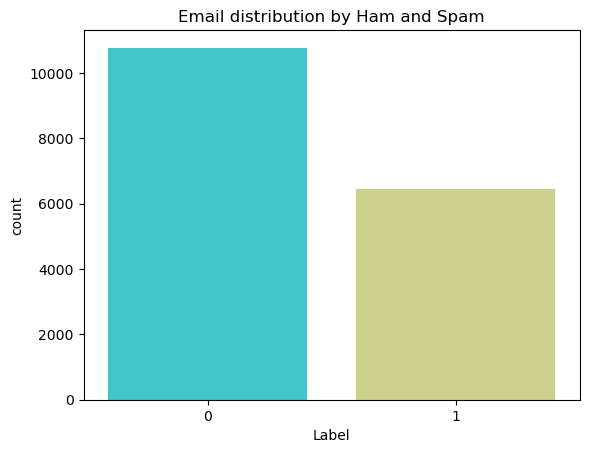

In [22]:
plt.figure()
sns.countplot(x='Label',data=emails,palette='rainbow')
plt.title('Email distribution by Ham and Spam')
plt.show()

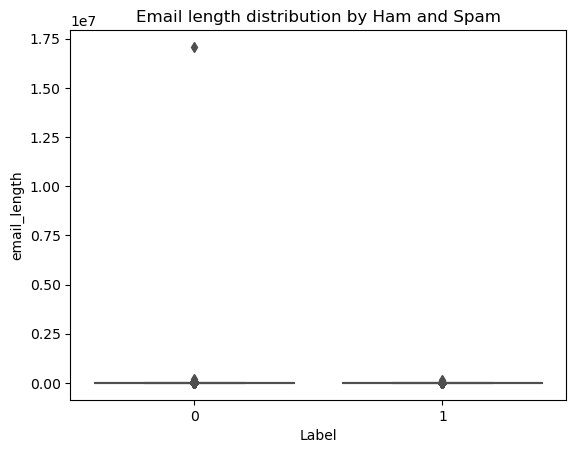

In [23]:
plt.figure()
sns.boxplot(x='Label',y='email_length',data=emails,palette='rainbow')
plt.title('Email length distribution by Ham and Spam')
plt.show()

In [24]:
emails.isnull().sum()

Body            0
Label           0
email_length    0
dtype: int64

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

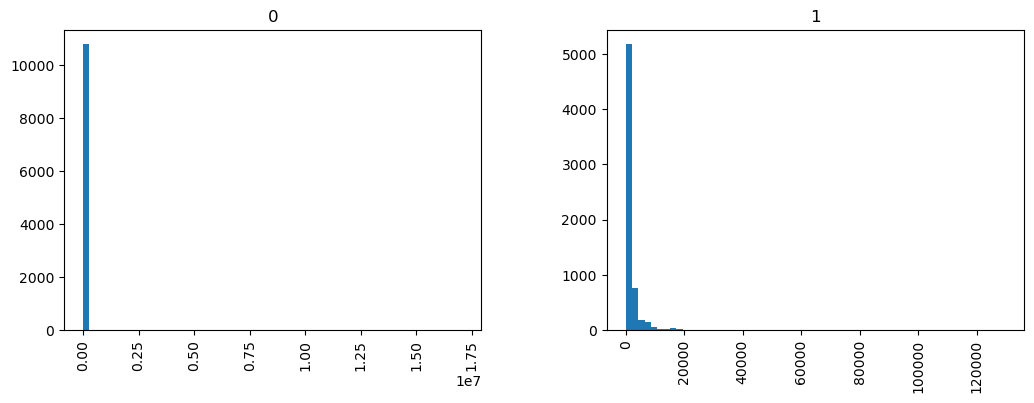

In [25]:
emails.hist(column='email_length',by='Label',bins=60, figsize=(12,4))

In [26]:
naive_bayes_classifiers(email_train, email_test, label_train, label_test)

MultinomialNB
[[3018  207]
 [  45 1898]] 

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3225
           1       0.90      0.98      0.94      1943

    accuracy                           0.95      5168
   macro avg       0.94      0.96      0.95      5168
weighted avg       0.95      0.95      0.95      5168

BernoulliNB
[[2791  434]
 [  27 1916]] 

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      3225
           1       0.82      0.99      0.89      1943

    accuracy                           0.91      5168
   macro avg       0.90      0.93      0.91      5168
weighted avg       0.92      0.91      0.91      5168

GaussianNB
[[2533  692]
 [ 163 1780]] 

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      3225
           1       0.72      0.92      0.81      1943

    accuracy                           0.83      5168
   m

In [ ]:
# SV_classifier(email_train, email_test, label_train, label_test)

In [92]:
RF_classifier(email_train, email_test, label_train, label_test)

[[3163   64]
 [  62 1879]] 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3227
           1       0.97      0.97      0.97      1941

    accuracy                           0.98      5168
   macro avg       0.97      0.97      0.97      5168
weighted avg       0.98      0.98      0.98      5168



In [28]:
KNN_classifer(email_train, email_test, label_train, label_test)

2
[[2809  416]
 [ 201 1742]]


              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3225
           1       0.81      0.90      0.85      1943

    accuracy                           0.88      5168
   macro avg       0.87      0.88      0.88      5168
weighted avg       0.89      0.88      0.88      5168



In [30]:
models

[('MNB', MultinomialNB()),
 ('BNB', BernoulliNB()),
 ('GNB', GaussianNB()),
 ('RF', RandomForestClassifier()),
 ('KNN', KNeighborsClassifier(n_neighbors=2))]

MNB:0.9462517289073306 (0.009549513575567043)
BNB:0.9089262539308989 (0.011853578938399579)
GNB:0.8279701767786241 (0.017779996905807265)
RF:0.9747841704341363 (0.004233577463580433)
KNN:0.8769920108998577 (0.00954163958459769)
['MNB', 'BNB', 'GNB', 'RF', 'KNN'] [array([0.93283582, 0.94776119, 0.9668325 , 0.93864013, 0.93283582,
       0.94776119, 0.9526971 , 0.94439834, 0.94854772, 0.95020747]), array([0.90298507, 0.90298507, 0.91044776, 0.89718076, 0.8946932 ,
       0.93034826, 0.92033195, 0.90456432, 0.89958506, 0.92614108]), array([0.82504146, 0.82421227, 0.85489221, 0.80762852, 0.80514096,
       0.84245439, 0.85145228, 0.82489627, 0.80414938, 0.83983402]), array([0.97263682, 0.97761194, 0.96766169, 0.973466  , 0.9800995 ,
       0.97927032, 0.98008299, 0.97012448, 0.97095436, 0.97593361]), array([0.87230514, 0.87313433, 0.85737977, 0.87396352, 0.87976783,
       0.88971808, 0.87883817, 0.8879668 , 0.86887967, 0.8879668 ])]


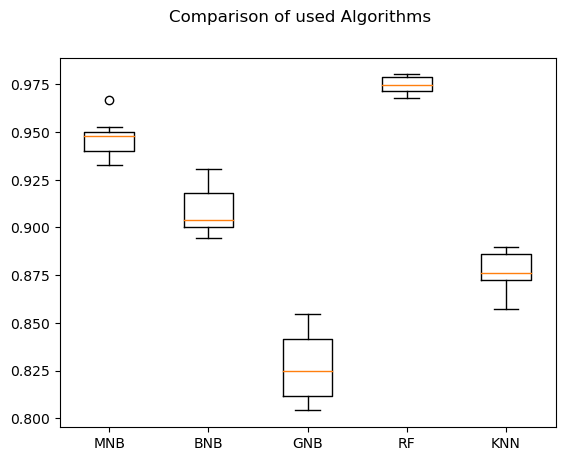

In [31]:
algorithm_evaluation(models, email_train, label_train)

In [110]:
text = input('Type here something and see if it belongs to spam: \n')
classify(text)

Type here something and see if it belongs to spam: 
  PAYOUT VERIFICATION  Congratulation!  We are trying to reach you. Please confirm your email.your account credit Will remain pending your confirmation. You've Won, $50,000 Please confirm receipt now This transaction may only appear on your account after validate your info.
Ham


In [ ]:
te